In [ ]:
!pip install requests
!pip install pandas
!pip install mp-api
!pip install requests-html

In [1]:
import csv
import os
import pandas as pd
import math
import random
import seaborn as sb
import subprocess

In [2]:
ROOT_DIR = os.path.abspath("")
#DATA_DIR = os.path.join(ROOT_DIR, 'CrabNet/data/materials_data')
DATA_DIR = os.path.join(ROOT_DIR, 'CrabNet/data/materials_data/example_materials_property')
TRAINING_CSV_FILE = os.path.join(ROOT_DIR, "Vacancyenergydata.csv")
API_KEY = "3XX6x9Nd3cKWf9Q4wpaio64CBHFp2uDq"
TRAINING_DATA = []

print(DATA_DIR)

/home/murimikelvin/ML-perovskites-project/CrabNet/data/materials_data/example_materials_property


## Step1:Collecting data and cleaning the data.


#### Load Training data.

In [3]:
df = pd.read_csv(TRAINING_CSV_FILE)
print(df.columns)
df = df[['Chemical formula', 'Vacancy energy [eV/O atom]']]
new_names = {
    'Chemical formula': 'chem_formula',
    'Vacancy energy [eV/O atom]': 'e_ovac'
}
df.rename(columns=new_names, inplace=True)
df = df.to_dict("records")
df = [{'chem_formula': m['chem_formula'], 'e_ovac': float(m['e_ovac']) if m['e_ovac'] != '-' else '-'} for m in df]

df[:10]

Index(['Chemical formula', 'A', 'B', 'In literature', 'Valence A', 'Valence B',
       'Radius A [ang]', 'Radius B [ang]', 'Lowest distortion',
       'Formation energy [eV/atom]', 'Stability [eV/atom]',
       'Magnetic moment [mu_B]', 'Volume per atom [A^3/atom]', 'Band gap [eV]',
       'a [ang]', 'b [ang]', 'c [ang]', 'alpha [deg]', 'beta [deg]',
       'gamma [deg]', 'Vacancy energy [eV/O atom]'],
      dtype='object')


[{'chem_formula': 'Ac2O3', 'e_ovac': 3.15},
 {'chem_formula': 'AcAgO3', 'e_ovac': 0.817},
 {'chem_formula': 'AcAlO3', 'e_ovac': 6.695},
 {'chem_formula': 'AcAsO3', 'e_ovac': 3.634},
 {'chem_formula': 'AcAuO3', 'e_ovac': 0.807},
 {'chem_formula': 'AcBO3', 'e_ovac': 4.163},
 {'chem_formula': 'AcBaO3', 'e_ovac': -1.771},
 {'chem_formula': 'AcBeO3', 'e_ovac': -0.08},
 {'chem_formula': 'AcBiO3', 'e_ovac': 2.653},
 {'chem_formula': 'AcCaO3', 'e_ovac': -1.025}]

## Step 2: Data splitting

####  Splitting model data

In [4]:
# Splitting the data into training and predicting and saving this data.
TRAINING_DATA = [m for m in df if m['e_ovac'] != '-']
PREDICTION_DATA = [m for m in df if m['e_ovac'] == '-']


print("Materials in the csv file without E_Ovac: ", len(PREDICTION_DATA))
print("Materials in the csv file with E_Ovac: ", len(TRAINING_DATA))
print("Total materials in the csv file: ", len(df))


Materials in the csv file without E_Ovac:  415
Materials in the csv file with E_Ovac:  4914
Total materials in the csv file:  5329


In [5]:
print(TRAINING_DATA[0])

{'chem_formula': 'Ac2O3', 'e_ovac': 3.15}


In [6]:
print(PREDICTION_DATA[0])

{'chem_formula': 'AcMgO3', 'e_ovac': '-'}


In [7]:
print(min([x.get('e_ovac') for x in TRAINING_DATA]))
print(max([x.get('e_ovac') for x in TRAINING_DATA]))

-21.785
6.962


#### Create Model Training Data (Create train.csv, val.csv, test.csv)

In [8]:
## Split the data into train, test, val

random.shuffle(TRAINING_DATA) # Shuffle the training data list on every run
split_ratio = "6:2:2" # Set the ratio at with to split the data into train, test and validation sets from the training data list

ratios = [round(int(r)/10 * len(TRAINING_DATA)) for r in split_ratio.split(':')] # Get the number of materials from the training data list according tp the ratio

# Get X amount of data from the training dataset accoring to the set rratio
train_set = TRAINING_DATA[:ratios[0]] 
test_set = TRAINING_DATA[ratios[0]:(ratios[0] + ratios[1])]
val_set = TRAINING_DATA[(ratios[0] + ratios[1]):]

print(len(train_set), len(test_set), len(val_set))
print(ratios, sum(ratios), len(TRAINING_DATA))

print(train_set[:5])
print(test_set[:5])
print(val_set[:5])

2948 983 983
[2948, 983, 983] 4914 4914
[{'chem_formula': 'AuLaO3', 'e_ovac': -4.391}, {'chem_formula': 'SmDyO3', 'e_ovac': 4.233}, {'chem_formula': 'TaMnO3', 'e_ovac': -5.179}, {'chem_formula': 'CsCaO3', 'e_ovac': -1.791}, {'chem_formula': 'NiSiO3', 'e_ovac': 0.759}]
[{'chem_formula': 'GdSbO3', 'e_ovac': 1.234}, {'chem_formula': 'IrTiO3', 'e_ovac': -1.56}, {'chem_formula': 'ScSmO3', 'e_ovac': -3.864}, {'chem_formula': 'NpMnO3', 'e_ovac': 5.185}, {'chem_formula': 'RhTaO3', 'e_ovac': 4.232}]
[{'chem_formula': 'YbNbO3', 'e_ovac': 5.047}, {'chem_formula': 'HoTlO3', 'e_ovac': 0.482}, {'chem_formula': 'YbVO3', 'e_ovac': 3.823}, {'chem_formula': 'SbNiO3', 'e_ovac': 0.167}, {'chem_formula': 'EuCeO3', 'e_ovac': -1.183}]


In [9]:
## Save data to CSV

fields = ['formula', 'target']
train_rows = [[data.get('chem_formula'), data.get('e_ovac')] for data in train_set]
val_rows = [[data.get('chem_formula'), data.get('e_ovac')] for data in val_set]
test_rows = [[data.get('chem_formula'), data.get('e_ovac')] for data in test_set]

# print(rows)
## Create train.csv with train_set data
with open(os.path.join(DATA_DIR, 'train.csv'), 'w') as train_file:
    csvwriter = csv.writer(train_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(train_rows)

## Create val.csv with train_set data
with open(os.path.join(DATA_DIR, 'val.csv'), 'w') as val_file:
    csvwriter = csv.writer(val_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(val_rows)

## Create test.csv with train_set data
with open(os.path.join(DATA_DIR, 'test.csv'), 'w') as test_file:
    csvwriter = csv.writer(test_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(test_rows)
    

#### Train the crabnet model

In [12]:



os.chdir ('CrabNet')
command = f"python train_crabnet.py"

process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
for line in process.stdout:
    print(line.decode("utf-8"), end='')


Property "example_materials_property" selected for training

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters

loading data with up to 3 elements in the formula
training with batchsize 256 (2**8.000)
loading data with up to 3 elements in the formula
stepping every 12 training passes, cycling lr every 1 epochs
checkin at 2 epochs to match lr scheduler
Epoch: 0/40 --- train mae: 3.24 val mae: 3.26
Epoch: 1/40 --- train mae: 3.2 val mae: 3.23
Epoch: 3/40 --- train mae: 3.05 val mae: 3.13
Epoch: 5/40 --- train mae: 2.93 val mae: 3.06
Epoch: 7/40 --- train mae: 2.89 val mae: 3.05
Epoch: 9/40 --- train mae: 2.86 val mae: 3.04
Epoch: 11/40 --- train mae: 2.85 val mae: 3.01
Epoch: 13/40 --- train mae: 2.82 val mae: 2.98
Epoch: 15/40 --- train mae: 2.81 val mae: 2.99
Epoch: 17/40 --- train mae: 2.8 val mae: 2.98
Epoch: 19/40 --- train mae: 2.8 val mae: 2.99
Epoch: 21/40 --- train mae: 2.75 val mae: 2.99
Epoch: 23/40 --- 

#### Analyzing training performance

In [53]:


TRAIN_DIR = os.path.join(ROOT_DIR, "CrabNet/model_predictions/")
print(TRAIN_DIR)
csv_files = os.listdir(TRAIN_DIR)

trained_data = []
for _file in csv_files:
    with open(os.path.join(TRAIN_DIR, _file)) as train_file:
        csv_reader = csv.reader(train_file)
        
        row_count = 0
        for row in csv_reader:
            if row_count != 0:
#                 print(row)
                trained_data.append({
                    "structure": row[1],
                    "target_e_ovac": float(row[2]),
                    "predicted_e_ovac": float(row[3]),
                    "error": abs(float(row[2]) - float(row[3]))
                    
                })
            
            row_count += 1

            
print(trained_data[:5])
print(len(trained_data))
 
df = pd.DataFrame(trained_data)
df = df.sort_values(by = 'error')
df.to_csv('trained_data.csv', index=False)


print(df.head())
print(len(trained_data))

/home/murimikelvin/ML-perovskites-project/CrabNet/model_predictions/
[{'structure': 'GdSbO3', 'target_e_ovac': 1.2339999675750732, 'predicted_e_ovac': -0.2517535090446472, 'error': 1.4857534766197205}, {'structure': 'IrTiO3', 'target_e_ovac': -1.559999942779541, 'predicted_e_ovac': -0.8174614906311035, 'error': 0.7425384521484375}, {'structure': 'ScSmO3', 'target_e_ovac': -3.864000082015991, 'predicted_e_ovac': 3.2340800762176514, 'error': 7.098080158233643}, {'structure': 'NpMnO3', 'target_e_ovac': 5.184999942779541, 'predicted_e_ovac': 1.9820210933685303, 'error': 3.2029788494110107}, {'structure': 'RhTaO3', 'target_e_ovac': 4.23199987411499, 'predicted_e_ovac': -0.3659976124763489, 'error': 4.597997486591339}]
4914
     structure  target_e_ovac  predicted_e_ovac     error
3441    RbLiO3         -2.935         -2.935393  0.000393
3848      Y2O3          1.075          1.073022  0.001978
530       YUO3          2.281          2.283474  0.002474
1893    ScAgO3         -1.495         -1

Text(0, 0.5, 'Predicted Eovac(eV/O atom)')

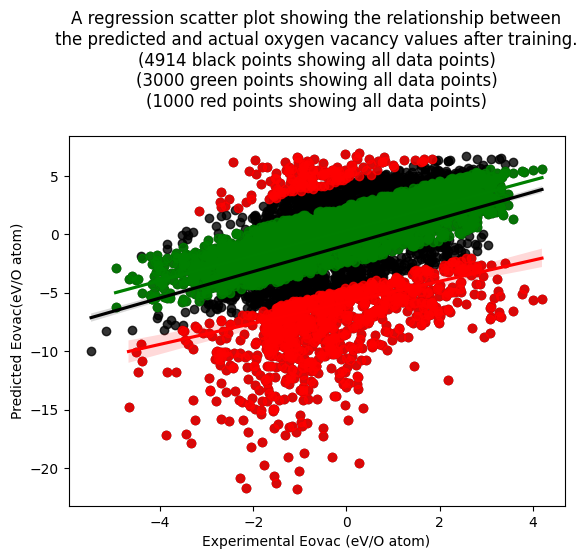

In [61]:

csv_df_all = pd.read_csv('trained_data.csv')
csv_df_best = pd.read_csv('trained_data.csv')[:3000]
csv_df_worst = pd.read_csv('trained_data.csv')[-1000:]

ax = sb.regplot(x='predicted_e_ovac', y='target_e_ovac', data=csv_df_all, scatter_kws={"color": "black"}, line_kws={"color": "black"})
ax = sb.regplot(x='predicted_e_ovac', y='target_e_ovac', data=csv_df_best, scatter_kws={"color": "green"}, line_kws={"color": "green"})
ax = sb.regplot(x='predicted_e_ovac', y='target_e_ovac', data=csv_df_worst, scatter_kws={"color": "red"}, line_kws={"color": "red"})

ax.set_title(f"A regression scatter plot showing the relationship between\n"
             f"the predicted and actual oxygen vacancy values after training.\n"
             f"({len(csv_df_all)} black points showing all data points)\n"
             f"({len(csv_df_best)} green points showing all data points)\n"
             f"({len(csv_df_worst)} red points showing all data points)\n")
ax.set_xlabel("Experimental Eovac (eV/O atom)")
ax.set_ylabel("Predicted Eovac(eV/O atom)")


#### Create Prediction Data (Create train.csv, val.csv, test.csv)

In [62]:
## Split the data into train, test, val

random.shuffle(PREDICTION_DATA) # Shuffle the training data list on every run
split_ratio = "6:2:2" # Set the ratio at with to split the data into train, test and validation sets from the training data list

ratios = [round(int(r)/10 * len(PREDICTION_DATA)) for r in split_ratio.split(':')] # Get the number of materials from the training data list according tp the ratio

# Get X amount of data from the training dataset accoring to the set rratio
train_set = PREDICTION_DATA[:ratios[0]] 
test_set = PREDICTION_DATA[ratios[0]:(ratios[0] + ratios[1])]
val_set = PREDICTION_DATA[(ratios[0] + ratios[1]):]

print(len(train_set), len(test_set), len(val_set))
print(ratios, sum(ratios), len(PREDICTION_DATA))

print(train_set[:5])
print(test_set[:5])
print(val_set[:5])


249 83 83
[249, 83, 83] 415 415
[{'chem_formula': 'TaCaO3', 'e_ovac': '-'}, {'chem_formula': 'TaCsO3', 'e_ovac': '-'}, {'chem_formula': 'CePbO3', 'e_ovac': '-'}, {'chem_formula': 'ZnTaO3', 'e_ovac': '-'}, {'chem_formula': 'UNdO3', 'e_ovac': '-'}]
[{'chem_formula': 'DyCoO3', 'e_ovac': '-'}, {'chem_formula': 'PmPbO3', 'e_ovac': '-'}, {'chem_formula': 'FeBaO3', 'e_ovac': '-'}, {'chem_formula': 'VCsO3', 'e_ovac': '-'}, {'chem_formula': 'UCsO3', 'e_ovac': '-'}]
[{'chem_formula': 'FeSbO3', 'e_ovac': '-'}, {'chem_formula': 'NpBiO3', 'e_ovac': '-'}, {'chem_formula': 'YCoO3', 'e_ovac': '-'}, {'chem_formula': 'NpHfO3', 'e_ovac': '-'}, {'chem_formula': 'NiPmO3', 'e_ovac': '-'}]


In [63]:
## Save data to CSV

fields = ['formula', 'target']
train_rows = [[data.get('chem_formula'), random.randint(-1, 1)] for data in train_set]
val_rows = [[data.get('chem_formula'), random.randint(-1, 1)] for data in val_set]
test_rows = [[data.get('chem_formula'), random.randint(-1, 1)] for data in test_set]

# print(rows)
## Create train.csv with train_set data
with open(os.path.join(DATA_DIR, 'train.csv'), 'w') as train_file:
    csvwriter = csv.writer(train_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(train_rows)

## Create val.csv with train_set data
with open(os.path.join(DATA_DIR, 'val.csv'), 'w') as val_file:
    csvwriter = csv.writer(val_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(val_rows)

## Create test.csv with train_set data
with open(os.path.join(DATA_DIR, 'test.csv'), 'w') as test_file:
    csvwriter = csv.writer(test_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(test_rows)
    

In [64]:
print(min([x.get('e_ovac') for x in TRAINING_DATA]))

-21.785


#### Predicting EOvac values 

In [65]:
#os.chdir ('CrabNet')

command = f"python predict_crabnet.py"

process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
for line in process.stdout:
    print(line.decode("utf-8"), end='')

              example_materials_property             
calculating train mae
loading data with up to 3 elements in the formula
example_materials_property mae: 1.57
-----------------------------------------------------
calculating val mae
loading data with up to 3 elements in the formula
example_materials_property mae: 1.39
-----------------------------------------------------
calculating test mae
loading data with up to 3 elements in the formula
example_materials_property mae: 1.48


#### Analyze predicted values

In [66]:
## Read the predictions from the csv files

PRED_DIR = os.path.join(ROOT_DIR, "CrabNet/model_predictions/")
print(PRED_DIR)
csv_files = os.listdir(PRED_DIR)

predicted_data = []
for _file in csv_files:
    with open(os.path.join(PRED_DIR, _file)) as train_file:
        csv_reader = csv.reader(train_file)
        
        row_count = 0
        for row in csv_reader:
            if row_count != 0:
#                 print(row)
                predicted_data.append({
                    "structure": row[1],
                    "predicted_e_ovac": float(row[3])
                })
            
            row_count += 1

            
print(predicted_data[:5])
print(len(predicted_data))
 

/home/murimikelvin/ML-perovskites-project/CrabNet/model_predictions/
[{'structure': 'DyCoO3', 'predicted_e_ovac': 1.324047327041626}, {'structure': 'PmPbO3', 'predicted_e_ovac': -0.7751941680908203}, {'structure': 'FeBaO3', 'predicted_e_ovac': 0.503066897392273}, {'structure': 'VCsO3', 'predicted_e_ovac': -1.0734333992004395}, {'structure': 'UCsO3', 'predicted_e_ovac': 0.7140606641769409}]
415


In [67]:
print(min([x.get('predicted_e_ovac') for x in predicted_data]))
print(max([x.get('predicted_e_ovac') for x in predicted_data]))

-3.6254987716674805
3.430835485458374


In [68]:
df = pd.DataFrame(predicted_data)
df = df.sort_values(by = 'predicted_e_ovac')
df.to_csv('predictions.csv', index=False)


print(df.head())
print(len(predicted_data))

    structure  predicted_e_ovac
146    NiLiO3         -3.625499
184    NiBeO3         -3.597558
358    FeNaO3         -3.430162
318     Ca2O3         -3.076788
327    CaNaO3         -3.042754
415


##### Plot of the top and bottom 20 materials

Text(0.5, 0, 'Chemical Structure')

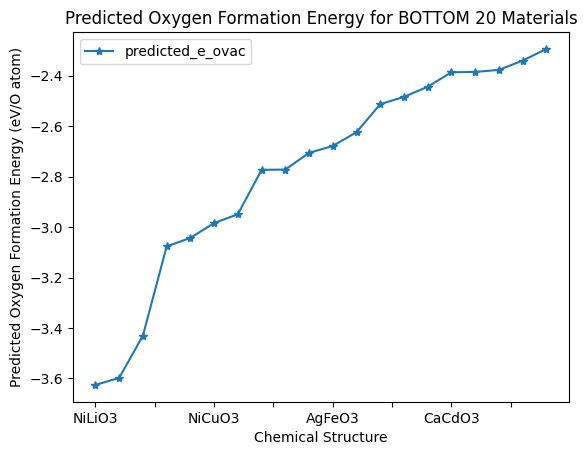

In [69]:
NUMBER = 20

new_df = (df[:NUMBER])

ax = new_df.plot(style='*-', x='structure', y='predicted_e_ovac')
ax.set_title(f"Predicted Oxygen Formation Energy for BOTTOM {NUMBER} Materials")
ax.set_ylabel('Predicted Oxygen Formation Energy (eV/O atom)')
ax.set_xlabel("Chemical Structure")

Text(0.5, 0, 'Chemical Structure')

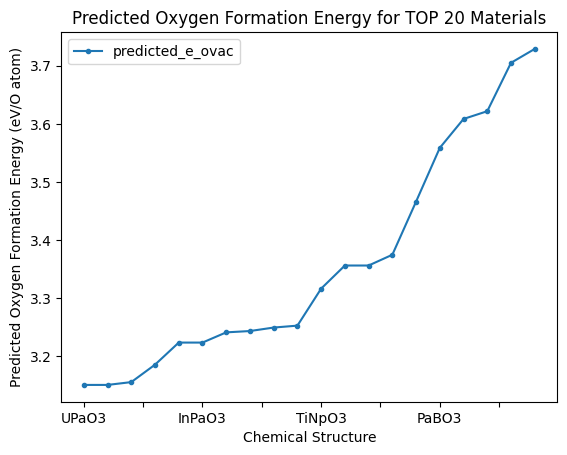

In [24]:
NUMBER = 20

new_df = df[-NUMBER:]

ax = new_df.plot(style='.-', x='structure', y='predicted_e_ovac')
ax.set_title(f"Predicted Oxygen Formation Energy for TOP {NUMBER} Materials")
ax.set_ylabel('Predicted Oxygen Formation Energy (eV/O atom)')
ax.set_xlabel("Chemical Structure")